<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Feature_Selection_Filter%2Bemb%2BPermutation_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔬 DEMOSTRACIÓN: Limitaciones de Feature Selection por Filter Methods

1. GENERANDO DATOS SINTÉTICOS CON INTERACCIONES
Dimensiones del dataset: (1000, 10)
Distribución de clases:
1    500
0    500
Name: count, dtype: int64


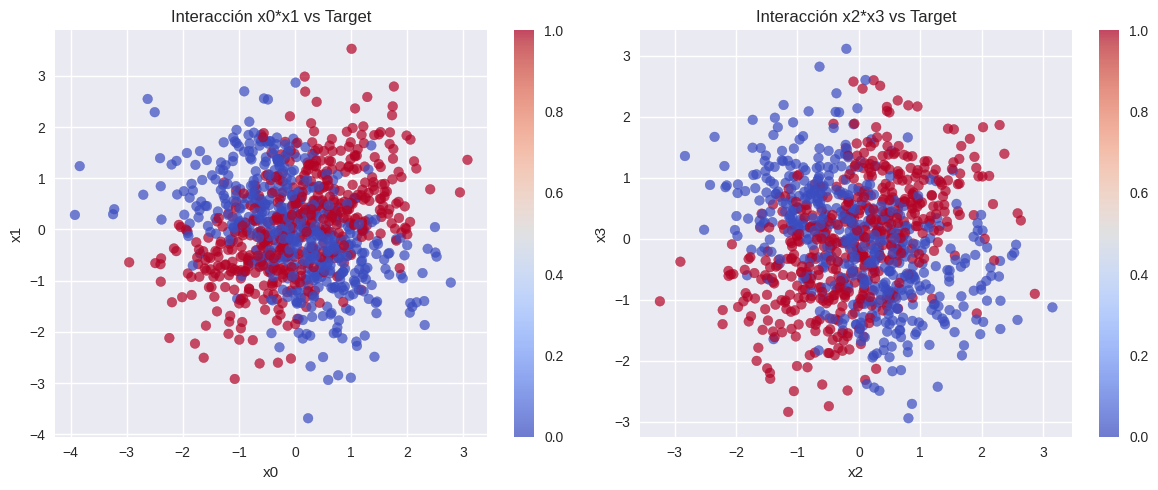


2. ANÁLISIS CON MÉTODOS FILTER (Correlaciones Individuales)
Correlaciones individuales con el target:
  feature  correlation_with_target
5      x5                 0.059658
1      x1                 0.046029
0      x0                 0.036362
4      x4                 0.035297
8      x8                 0.021270
6      x6                 0.014436
7      x7                 0.014340
2      x2                 0.011358
3      x3                 0.008108
9      x9                 0.000757


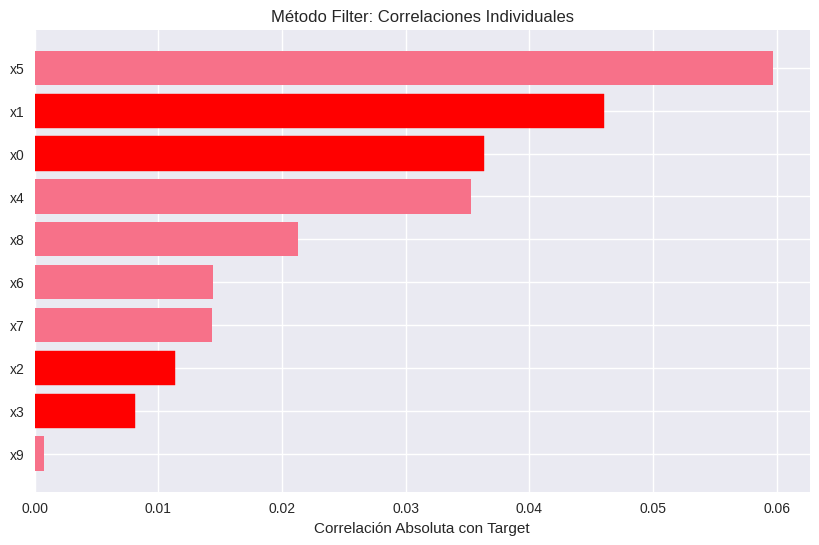

❌ PROBLEMA: Los métodos filter no detectan que x0, x1, x2, x3 son importantes
   porque individualmente tienen baja correlación con el target

3. APLICANDO MÉTODOS FILTER TRADICIONALES
Scores de métodos filter:
  feature  anova_f_score  mutual_info_score
0      x0       3.465596           0.009554
5      x5       3.303071           0.009195
6      x6       2.807418           0.000000
4      x4       2.723977           0.028480
1      x1       1.685823           0.000000
3      x3       1.496077           0.006648
2      x2       0.144634           0.004970
8      x8       0.144063           0.000000
9      x9       0.058271           0.011831
7      x7       0.000683           0.001700


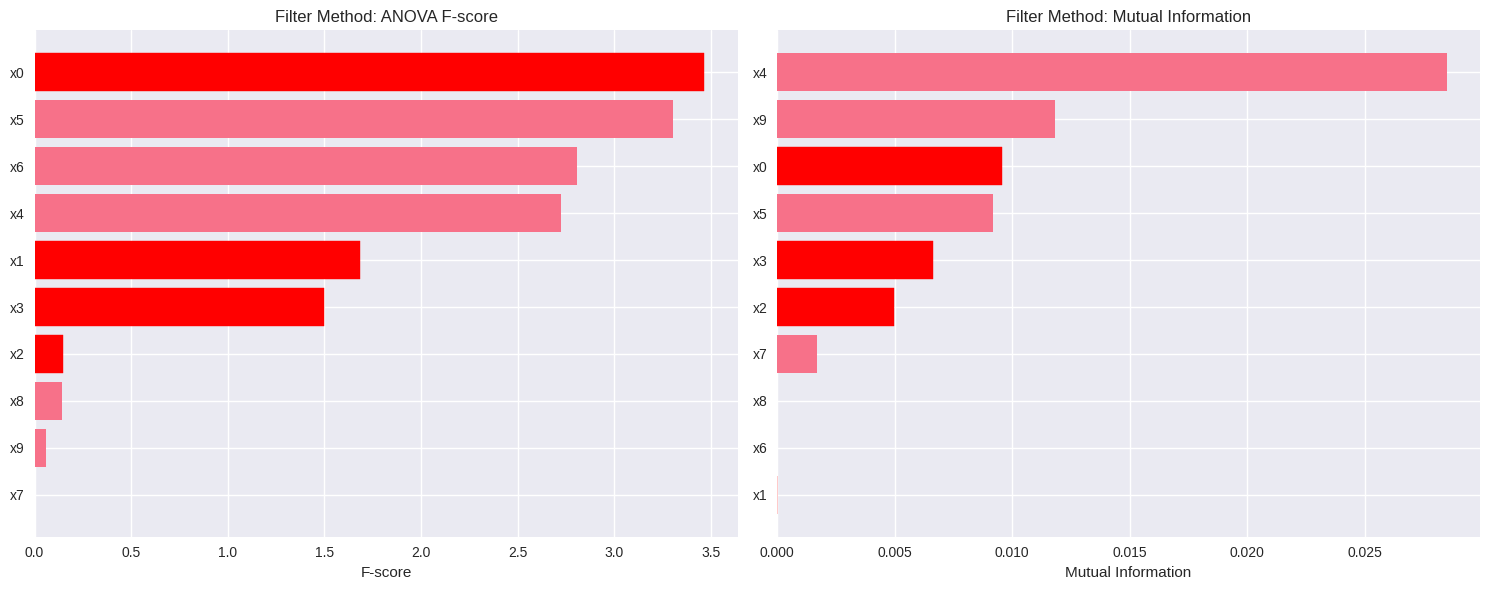


4. MÉTODOS QUE CAPTURAN INTERACCIONES (Random Forest)
Importancia de características (Random Forest):
  feature  rf_importance  permutation_importance
0      x0       0.142953                0.134000
2      x2       0.119988                0.116333
1      x1       0.117667                0.131000
3      x3       0.113842                0.118333
4      x4       0.097805               -0.037000
5      x5       0.089602               -0.036667
6      x6       0.084464               -0.047667
7      x7       0.084404               -0.013000
8      x8       0.077617               -0.011333
9      x9       0.071659               -0.033333


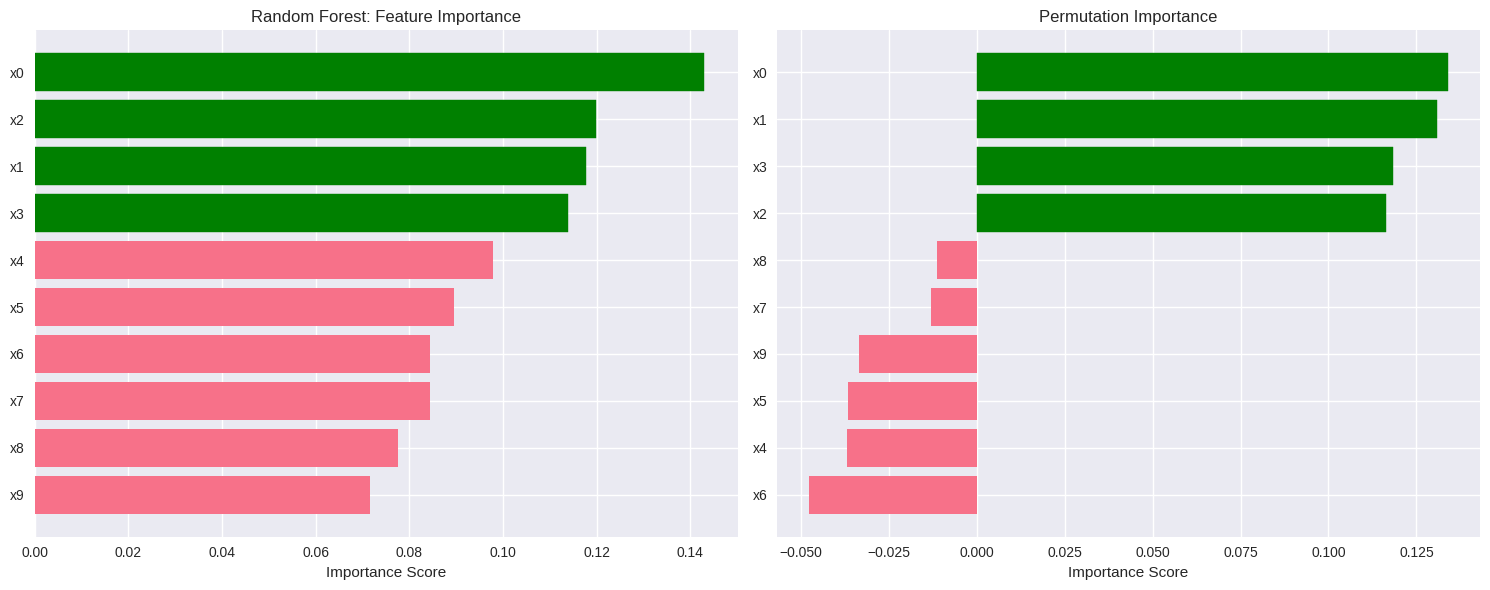

✅ Random Forest SÍ detecta que x0, x1, x2, x3 son importantes

5. COMPARACIÓN DE RENDIMIENTO EN CLASIFICACIÓN
Comparación de métodos de feature selection:
                      Method         Features_Selected  Accuracy  F1-Score
0  Todas las características                Todas (10)  0.716667  0.707904
1               ANOVA Filter     ['x0' 'x4' 'x5' 'x6']  0.443333  0.433898
2         Mutual Info Filter     ['x0' 'x4' 'x5' 'x9']  0.490000  0.466899
3    Random Forest Selection  ['x0', 'x2', 'x1', 'x3']  0.926667  0.926667


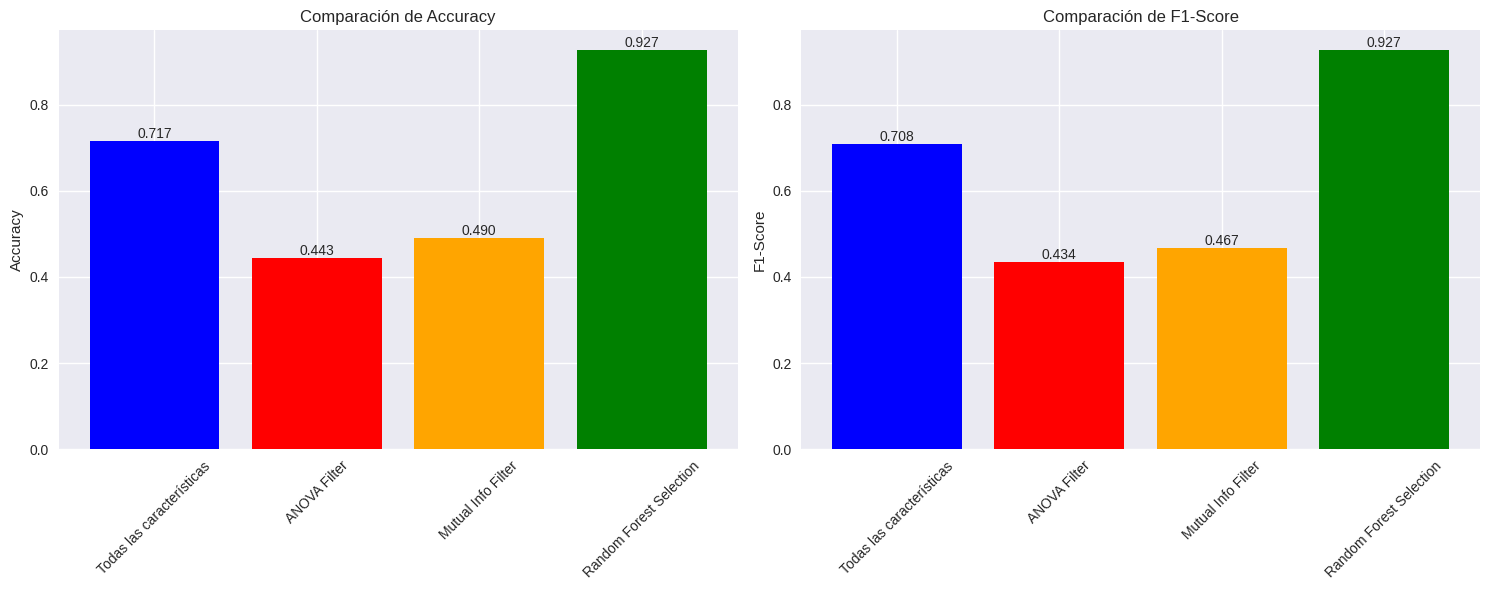


6. ANÁLISIS DE INTERACCIONES CON PRODUCTOS DE CARACTERÍSTICAS
Top 10 interacciones más correlacionadas con el target:
   interaction  correlation
0        x0*x1     0.507704
17       x2*x3     0.501645
13       x1*x6     0.070051
1        x0*x2     0.069703
40       x6*x8     0.060968
12       x1*x5     0.055549
23       x2*x9     0.052787
10       x1*x3     0.050442
22       x2*x8     0.048248
7        x0*x8     0.045866


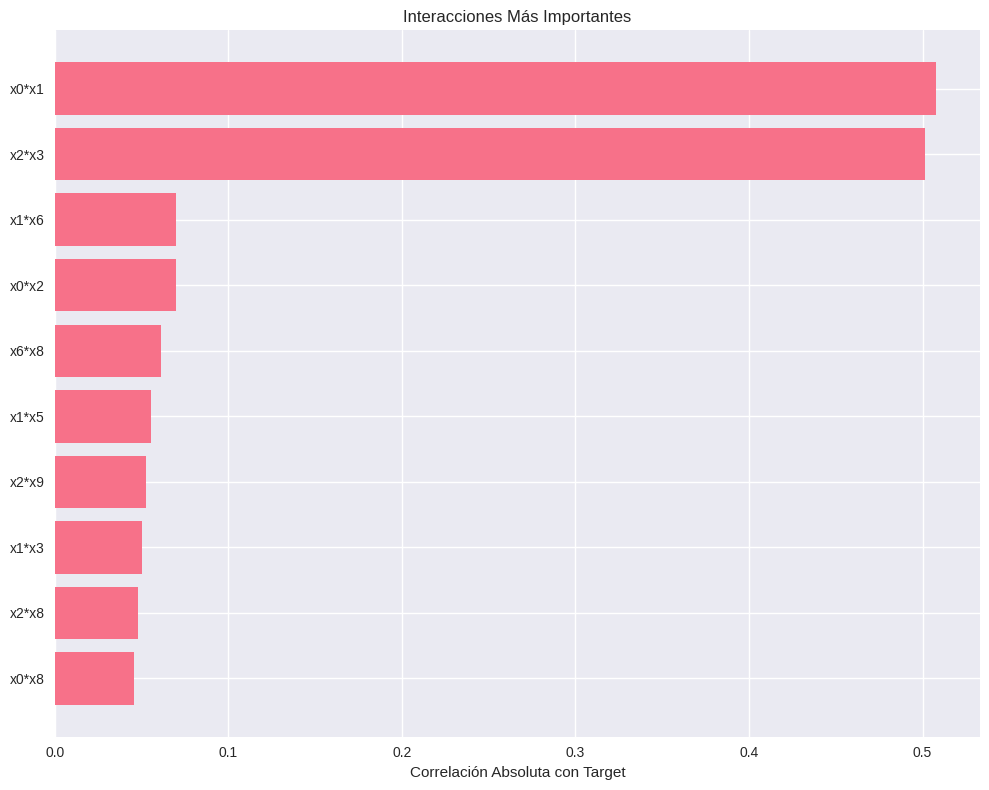


7. CONCLUSIONES Y RECOMENDACIONES

🔍 **CONCLUSIONES:**
1. Los métodos FILTER (ANOVA, Mutual Information) fallan en detectar
   características que son importantes solo a través de interacciones
2. x0, x1, x2, x3 tienen baja importancia individual pero alta importancia
   en interacciones
3. Los métodos BASADOS EN MODELOS (Random Forest) capturan mejor las interacciones

💡 **RECOMENDACIONES:**
• Usar métodos filter para pre-selección rápida o con datasets muy grandes
• Complementar con métodos wrapper o embedded para capturar interacciones
• Considerar crear características de interacción manualmente
• Random Forest y Gradient Boosting son buenos para capturar interacciones
• Validar siempre con el rendimiento del modelo final

📊 **RESULTADO CLAVE:**
   • Accuracy con selección ANOVA: 0.443
   • Accuracy con selección RF:    0.927
   • Mejora: 109.0%

🎯 **MÉTODOS RECOMENDADOS POR ESCENARIO:**
   • Dataset muy grande (>100K muestras): Filter Methods, Mutual Information
   • Interaccione

In [1]:
"""
Feature Selection: Comparación de Métodos Filter vs Métodos que Capturan Interacciones

Este notebook demuestra cómo los métodos de filter selection pueden fallar al
detectar características importantes cuando existen interacciones entre variables.
"""

# Instalación de librerías necesarias


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔬 DEMOSTRACIÓN: Limitaciones de Feature Selection por Filter Methods")

# =============================================================================
# 1. GENERACIÓN DE DATOS SINTÉTICOS CON INTERACCIONES
# =============================================================================

print("\n" + "="*60)
print("1. GENERANDO DATOS SINTÉTICOS CON INTERACCIONES")
print("="*60)

def generate_data_with_interactions(n_samples=1000, random_state=42):
    """
    Genera datos donde el target depende de interacciones entre variables,
    no de variables individuales.
    """
    np.random.seed(random_state)

    n_features = 10
    X = np.random.normal(0, 1, (n_samples, n_features))

    # El target depende SOLO de interacciones entre variables
    # y = f(x1*x2 + x3*x4) + ruido
    interaction_1 = X[:, 0] * X[:, 1]  # Interacción importante 1
    interaction_2 = X[:, 2] * X[:, 3]  # Interacción importante 2

    # Crear target basado en interacciones
    y_continuous = interaction_1 + interaction_2 + np.random.normal(0, 0.1, n_samples)
    y = (y_continuous > np.median(y_continuous)).astype(int)

    feature_names = [f'x{i}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y

    return df, X, y, feature_names

# Generar datos
df, X, y, feature_names = generate_data_with_interactions(1000)

print("Dimensiones del dataset:", X.shape)
print("Distribución de clases:")
print(pd.Series(y).value_counts())

# Visualizar las interacciones importantes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Interacción x0*x1
scatter1 = axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
axes[0].set_xlabel('x0')
axes[0].set_ylabel('x1')
axes[0].set_title('Interacción x0*x1 vs Target')
plt.colorbar(scatter1, ax=axes[0])

# Interacción x2*x3
scatter2 = axes[1].scatter(X[:, 2], X[:, 3], c=y, cmap='coolwarm', alpha=0.7)
axes[1].set_xlabel('x2')
axes[1].set_ylabel('x3')
axes[1].set_title('Interacción x2*x3 vs Target')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

# =============================================================================
# 2. ANÁLISIS DE CORRELACIONES INDIVIDUALES (MÉTODO FILTER)
# =============================================================================

print("\n" + "="*60)
print("2. ANÁLISIS CON MÉTODOS FILTER (Correlaciones Individuales)")
print("="*60)

# Matriz de correlación con el target
correlations = []
for i in range(X.shape[1]):
    corr = np.corrcoef(X[:, i], y)[0, 1]
    correlations.append(abs(corr))

corr_df = pd.DataFrame({
    'feature': feature_names,
    'correlation_with_target': correlations
}).sort_values('correlation_with_target', ascending=False)

print("Correlaciones individuales con el target:")
print(corr_df)

# Visualizar correlaciones
plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df['feature'], corr_df['correlation_with_target'])
plt.xlabel('Correlación Absoluta con Target')
plt.title('Método Filter: Correlaciones Individuales')
# Destacar las variables que SÍ participan en interacciones
for i, (bar, feature) in enumerate(zip(bars, corr_df['feature'])):
    if feature in ['x0', 'x1', 'x2', 'x3']:
        bar.set_color('red')
plt.gca().invert_yaxis()
plt.show()

print("❌ PROBLEMA: Los métodos filter no detectan que x0, x1, x2, x3 son importantes")
print("   porque individualmente tienen baja correlación con el target")

# =============================================================================
# 3. MÉTODOS FILTER TRADICIONALES
# =============================================================================

print("\n" + "="*60)
print("3. APLICANDO MÉTODOS FILTER TRADICIONALES")
print("="*60)

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Método Filter: SelectKBest con ANOVA F-value
k_best_anova = SelectKBest(score_func=f_classif, k=4)
X_train_anova = k_best_anova.fit_transform(X_train, y_train)
X_test_anova = k_best_anova.transform(X_test)

# Método Filter: SelectKBest con Mutual Information
k_best_mi = SelectKBest(score_func=mutual_info_classif, k=4)
X_train_mi = k_best_mi.fit_transform(X_train, y_train)
X_test_mi = k_best_mi.transform(X_test)

# Obtener scores y features seleccionadas
anova_scores = k_best_anova.scores_
mi_scores = k_best_mi.scores_

# DataFrames con resultados
filter_results = pd.DataFrame({
    'feature': feature_names,
    'anova_f_score': anova_scores,
    'mutual_info_score': mi_scores
})

print("Scores de métodos filter:")
print(filter_results.sort_values('anova_f_score', ascending=False))

# Visualizar comparación de métodos filter
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ANOVA F-score
anova_sorted = filter_results.sort_values('anova_f_score', ascending=True)
bars1 = axes[0].barh(anova_sorted['feature'], anova_sorted['anova_f_score'])
axes[0].set_title('Filter Method: ANOVA F-score')
axes[0].set_xlabel('F-score')

# Mutual Information
mi_sorted = filter_results.sort_values('mutual_info_score', ascending=True)
bars2 = axes[1].barh(mi_sorted['feature'], mi_sorted['mutual_info_score'])
axes[1].set_title('Filter Method: Mutual Information')
axes[1].set_xlabel('Mutual Information')

# Resaltar variables importantes
for bars, sorted_df in zip([bars1, bars2], [anova_sorted, mi_sorted]):
    for bar, feature in zip(bars, sorted_df['feature']):
        if feature in ['x0', 'x1', 'x2', 'x3']:
            bar.set_color('red')

plt.tight_layout()
plt.show()

# =============================================================================
# 4. MÉTODOS QUE CAPTURAN INTERACCIONES (RANDOM FOREST)
# =============================================================================

print("\n" + "="*60)
print("4. MÉTODOS QUE CAPTURAN INTERACCIONES (Random Forest)")
print("="*60)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Importancia por impurity reduction
rf_importance = rf.feature_importances_

# Importancia por permutación
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42
)

# DataFrame con resultados
interaction_results = pd.DataFrame({
    'feature': feature_names,
    'rf_importance': rf_importance,
    'permutation_importance': perm_importance.importances_mean
}).sort_values('rf_importance', ascending=False)

print("Importancia de características (Random Forest):")
print(interaction_results)

# Visualizar importancias
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Importancia por impurity
rf_sorted = interaction_results.sort_values('rf_importance', ascending=True)
bars1 = axes[0].barh(rf_sorted['feature'], rf_sorted['rf_importance'])
axes[0].set_title('Random Forest: Feature Importance')
axes[0].set_xlabel('Importance Score')

# Importancia por permutación
perm_sorted = interaction_results.sort_values('permutation_importance', ascending=True)
bars2 = axes[1].barh(perm_sorted['feature'], perm_sorted['permutation_importance'])
axes[1].set_title('Permutation Importance')
axes[1].set_xlabel('Importance Score')

# Resaltar variables importantes
for bars, sorted_df in zip([bars1, bars2], [rf_sorted, perm_sorted]):
    for bar, feature in zip(bars, sorted_df['feature']):
        if feature in ['x0', 'x1', 'x2', 'x3']:
            bar.set_color('green')

plt.tight_layout()
plt.show()

print("✅ Random Forest SÍ detecta que x0, x1, x2, x3 son importantes")

# =============================================================================
# 5. COMPARACIÓN DE RENDIMIENTO
# =============================================================================

print("\n" + "="*60)
print("5. COMPARACIÓN DE RENDIMIENTO EN CLASIFICACIÓN")
print("="*60)

# Modelo con todas las características
lr_all = RandomForestClassifier(n_estimators=100, random_state=42)
lr_all.fit(X_train, y_train)
y_pred_all = lr_all.predict(X_test)
acc_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)

# Modelo con características seleccionadas por ANOVA
lr_anova =RandomForestClassifier(n_estimators=100, random_state=42)
lr_anova.fit(X_train_anova, y_train)
y_pred_anova = lr_anova.predict(X_test_anova)
acc_anova = accuracy_score(y_test, y_pred_anova)
f1_anova = f1_score(y_test, y_pred_anova)

# Modelo con características seleccionadas por Mutual Information
lr_mi = RandomForestClassifier(n_estimators=100, random_state=42)
lr_mi.fit(X_train_mi, y_train)
y_pred_mi = lr_mi.predict(X_test_mi)
acc_mi = accuracy_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)

# Modelo con características seleccionadas por Random Forest
# Seleccionamos las top 4 características según RF
rf_selected_features = interaction_results.head(4)['feature'].tolist()
feature_indices = [feature_names.index(f) for f in rf_selected_features]
X_train_rf = X_train[:, feature_indices]
X_test_rf = X_test[:, feature_indices]

lr_rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr_rf.fit(X_train_rf, y_train)
y_pred_rf = lr_rf.predict(X_test_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Resultados comparativos
results_comparison = pd.DataFrame({
    'Method': ['Todas las características', 'ANOVA Filter', 'Mutual Info Filter', 'Random Forest Selection'],
    'Features_Selected': [
        'Todas (10)',
        str(k_best_anova.get_feature_names_out(feature_names)),
        str(k_best_mi.get_feature_names_out(feature_names)),
        str(rf_selected_features)
    ],
    'Accuracy': [acc_all, acc_anova, acc_mi, acc_rf],
    'F1-Score': [f1_all, f1_anova, f1_mi, f1_rf]
})

print("Comparación de métodos de feature selection:")
print(results_comparison)

# Visualizar comparación de rendimiento
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
methods = results_comparison['Method']
accuracies = results_comparison['Accuracy']
f1_scores = results_comparison['F1-Score']

bars1 = axes[0].bar(methods, accuracies, color=['blue', 'red', 'orange', 'green'])
axes[0].set_title('Comparación de Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# F1-Score
bars2 = axes[1].bar(methods, f1_scores, color=['blue', 'red', 'orange', 'green'])
axes[1].set_title('Comparación de F1-Score')
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for ax in [axes[0], axes[1]]:
    for bar in ax.containers[0]:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. ANÁLISIS DE INTERACCIONES CON MATRICES DE CORRELACIÓN
# =============================================================================

print("\n" + "="*60)
print("6. ANÁLISIS DE INTERACCIONES CON PRODUCTOS DE CARACTERÍSTICAS")
print("="*60)

# Crear características de interacción
interaction_features = []
interaction_names = []

for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        interaction = X[:, i] * X[:, j]
        interaction_features.append(interaction)
        interaction_names.append(f'{feature_names[i]}*{feature_names[j]}')

# DataFrame con interacciones
interaction_df = pd.DataFrame(np.column_stack(interaction_features),
                             columns=interaction_names)
interaction_df['target'] = y

# Calcular correlación de interacciones con el target
interaction_correlations = []
for col in interaction_names:
    corr = abs(np.corrcoef(interaction_df[col], y)[0, 1])
    interaction_correlations.append(corr)

interaction_corr_df = pd.DataFrame({
    'interaction': interaction_names,
    'correlation': interaction_correlations
}).sort_values('correlation', ascending=False)

print("Top 10 interacciones más correlacionadas con el target:")
print(interaction_corr_df.head(10))

# Visualizar top interacciones
plt.figure(figsize=(10, 8))
top_interactions = interaction_corr_df.head(10).sort_values('correlation', ascending=True)
plt.barh(top_interactions['interaction'], top_interactions['correlation'])
plt.xlabel('Correlación Absoluta con Target')
plt.title('Interacciones Más Importantes')
plt.tight_layout()
plt.show()

# =============================================================================
# 7. CONCLUSIONES Y RECOMENDACIONES
# =============================================================================

print("\n" + "="*60)
print("7. CONCLUSIONES Y RECOMENDACIONES")
print("="*60)

print("\n🔍 **CONCLUSIONES:**")
print("1. Los métodos FILTER (ANOVA, Mutual Information) fallan en detectar")
print("   características que son importantes solo a través de interacciones")
print("2. x0, x1, x2, x3 tienen baja importancia individual pero alta importancia")
print("   en interacciones")
print("3. Los métodos BASADOS EN MODELOS (Random Forest) capturan mejor las interacciones")

print("\n💡 **RECOMENDACIONES:**")
print("• Usar métodos filter para pre-selección rápida o con datasets muy grandes")
print("• Complementar con métodos wrapper o embedded para capturar interacciones")
print("• Considerar crear características de interacción manualmente")
print("• Random Forest y Gradient Boosting son buenos para capturar interacciones")
print("• Validar siempre con el rendimiento del modelo final")

print("\n📊 **RESULTADO CLAVE:**")
print(f"   • Accuracy con selección ANOVA: {acc_anova:.3f}")
print(f"   • Accuracy con selección RF:    {acc_rf:.3f}")
print(f"   • Mejora: {((acc_rf - acc_anova)/acc_anova*100):.1f}%")

# Métodos recomendados para diferentes escenarios
print("\n🎯 **MÉTODOS RECOMENDADOS POR ESCENARIO:**")
recommendations = {
    "Dataset muy grande (>100K muestras)": ["Filter Methods", "Mutual Information"],
    "Interacciones complejas": ["Random Forest", "XGBoost", "Wrapper Methods"],
    "Tiempo limitado": ["Filter Methods", "Random Forest (rápido)"],
    "Máxima performance": ["Wrapper Methods", "Embedded Methods + Feature Engineering"]
}

for scenario, methods in recommendations.items():
    print(f"   • {scenario}: {', '.join(methods)}")

